## Regression Example - Bike Sharing Demand Prediction(Kaggle Data)

Dataset: https://www.kaggle.com/c/bike-sharing-demand/data

In [34]:
import pandas as pd

bike_df = pd.read_csv('./bike-sharing-demand/train.csv')
test_df = pd.read_csv('./bike-sharing-demand/test.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [35]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Column data  
- datetime: hourly date + timestamp  
- season: 1,2,3,4(Spring, Summer, Autumn, Winter)  
- holiday: 1(=holidays except saturday and sunday), 0(=not holiday)  
- workingday: 1(=Weekdays excepy holidays), 0(=not workingday)  
- weather: 1(=Sunny or bit Cloudy), 2(=Fog or Fog+Cloudy), 3(=light rain/snow), 4(=Heavy rain/snow)  
- temp: temperature(Celcius)  
- atemp: wind chill temperature(Celcius)  
- humidty: humidty  
- windspeed: windspeed  
- casual: # of non-registered users' sharing  
- registered: # of registered users' sharing  
- count: # of borrowing(target)

### Data Cleaning & Preprocessing

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [37]:
# Transform col 'Datetime'
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [38]:
drop_cols = ['datetime', 'casual', 'registered']
bike_df.drop(drop_cols, axis=1, inplace=True)

In [39]:
# Evaluation method: RMSLE(Root Mean Square Log Error)
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    # Caution: Sklearn mean_squared_log_error can cause overflow/underflow
    log_y = np.log1p(y) # Use 1+log(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### Log Transformation & Feature Encoding & Model Training/Prediction/Evaluation

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_features = bike_df.drop(['count'], axis=1, inplace=False)
y_target = bike_df['count']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)

LR_Reg = LinearRegression()
LR_Reg.fit(X_train, y_train)
pred = LR_Reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.200, RMSE: 143.387, MAE: 107.797


In [41]:
# Print Top 5 error
def get_top_error_data(y_test, pred, n_tops=5):
    
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    # np.abs: return absolute value of ndarray
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
   
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
240          834            189.0  645.0
89           835            215.0  620.0
1064         784            186.0  598.0
1579         884            326.0  558.0
1485         797            244.0  553.0


In regression, if big prediction error occurs, the first thing to consider is Dist. of target.  
Regression prefer Normal Dist. for target dist.  

<AxesSubplot:>

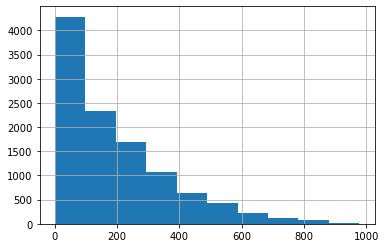

In [42]:
# Check Dist. of target
y_target.hist()

<AxesSubplot:>

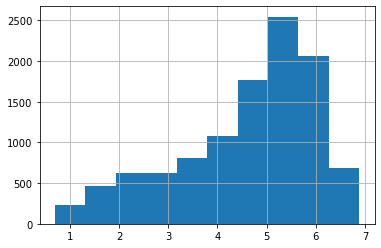

In [43]:
# To transform target dist. into normal dist., use log transformation
y_target_log_transform = np.log1p(y_target)
y_target_log_transform.hist()

In [44]:
y_target_log = np.log1p(y_target)

# Make new train/test dataset by log transformed y_target
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3)
LR_Reg = LinearRegression()
LR_Reg.fit(X_train, y_train)
pred = LR_Reg.predict(X_test)

# Use expm1 to re-transform to original target
y_test_exp = np.expm1(y_test)
# pred should also transformed to original data shape by np.expm1
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.025, RMSE: 159.247, MAE: 106.898


<AxesSubplot:>

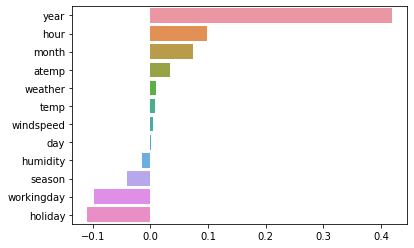

In [45]:
coef = pd.Series(LR_Reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [46]:
# year, hour, month have int/float data but it does not work as numerical data, but work as categorical data.  
# So we should transform these data with one-hot-encoding
X_features_encoding = pd.get_dummies(X_features, columns= 
                                    ['year','month','hour', 'holiday', 'workingday','season','weather'])

In [47]:
# Use one-hot-encoded feature dataset for train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features_encoding, y_target_log, test_size=0.3)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

LR_Reg = LinearRegression()
Ridge_Reg = Ridge(alpha=10)
Lasso_Reg = Lasso(alpha=0.01)

for model in [LR_Reg, Ridge_Reg, Lasso_Reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.580, RMSE: 91.187, MAE: 59.785
### Ridge ###
RMSLE: 0.582, RMSE: 92.177, MAE: 60.335
### Lasso ###
RMSLE: 0.632, RMSE: 107.630, MAE: 69.722


<AxesSubplot:>

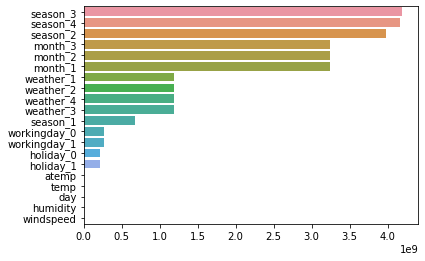

In [51]:
coef = pd.Series(LR_Reg.coef_, index=X_features_encoding.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [52]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RF_Reg = RandomForestRegressor(n_estimators=500)
GBM_Reg = GradientBoostingRegressor(n_estimators=500)
XGB_Reg = XGBRegressor(n_estimators=500)
LGBM_Reg = LGBMRegressor(n_estimators=500)

for model in [RF_Reg, GBM_Reg, XGB_Reg, LGBM_Reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

c:\Users\user\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### RandomForestRegressor ###
RMSLE: 0.342, RMSE: 46.838, MAE: 29.462
### GradientBoostingRegressor ###
RMSLE: 0.331, RMSE: 50.297, MAE: 31.587


c:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### XGBRegressor ###
RMSLE: 0.345, RMSE: 49.066, MAE: 30.533
### LGBMRegressor ###
RMSLE: 0.316, RMSE: 45.403, MAE: 27.855
